In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import glob
import sys
import pandasql as pdsql

sys.path.append("..")
import analysislib as alib

# ABOVE ZNONEOFTHE

In [2]:
sq = lambda q: pdsql.sqldf(q, globals())
sqflat = lambda q: alib.flatten(pdsql.sqldf(q, globals()).values.tolist())

In [15]:
compressionAlg = pd.read_csv("../../data/2025-03-27-time-14-19-14-fourth-run-compression-alg/master.csv", index_col=0)
compressionRatio = pd.read_csv("../../data/2025-03-28-time-12-00-50-fourth-run-compression-ratio/master.csv", index_col=0)

# Compression algorithm (on fio's random data)

In [17]:
compressionAlg.columns

Index(['cbSize', 'cioengine', 'ciodepth', 'crw', 'cnproc', 'cdevice',
       'cdirect', 'cmemlim', 'cfile', 'readBW_bytes', 'readBW',
       'writeBW_bytes', 'writeBW', 'avgreadlat_ns', 'avgreadlat',
       'avgwritelat_ns', 'avgwritelat', 'USR_UTIL_perc', 'SYS_UTIL_perc',
       'IOW_UTIL_perc', 'IDL_UTIL_perc', 'CPU_UTIL_perc'],
      dtype='object')

In [18]:
sq("""
    SELECT cdevice, crw, readBW, writeBW
    FROM compressionAlg
    WHERE cioengine="mmap"
""")

,cdevice,crw,readBW,writeBW
0,ssd,randread,2.6 GB,0.0 B
1,zram-lzo,randread,14.0 GB,0.0 B
2,zram-zstd,randread,13.6 GB,0.0 B
3,zram-lz4,randread,13.2 GB,0.0 B
4,ssd,randrw,787.6 MB,787.3 MB
5,zram-lzo,randrw,1.8 GB,1.8 GB
6,zram-zstd,randrw,1.3 GB,1.3 GB
7,zram-lz4,randrw,2.0 GB,2.0 GB
8,ssd,randwrite,0.0 B,1.2 GB
9,zram-lzo,randwrite,0.0 B,2.0 GB


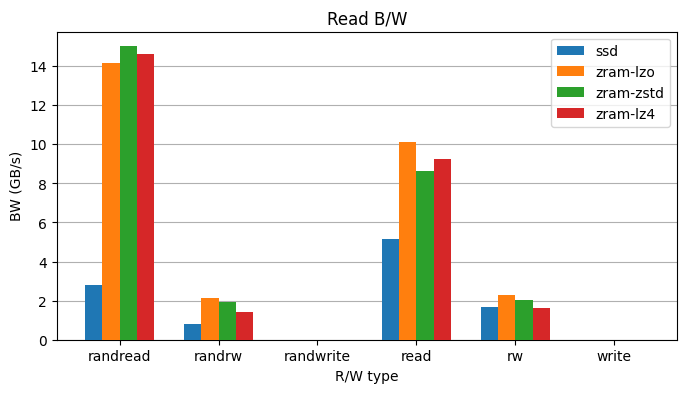

In [19]:
alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT crw FROM compressionAlg"),
    np.array(sqflat("SELECT readBW_bytes FROM compressionAlg WHERE cioengine='mmap' ORDER BY cdevice"))/10**9,
    labels=sqflat("SELECT DISTINCT cdevice FROM compressionAlg"),
    title="Read B/W",
    ylabel="BW (GB/s)",
    xlabel="R/W type",
    show=False
)
plt.savefig("../../processed-data/2025-03-28-heapdump/compAlg-randomdata-read.png")

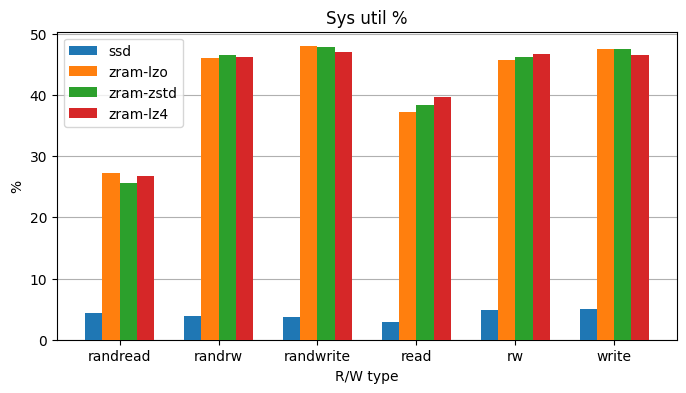

In [20]:
alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT crw FROM compressionAlg"),
    sqflat("SELECT SYS_UTIL_perc FROM compressionAlg WHERE cioengine='mmap' ORDER BY cdevice"),
    labels=sqflat("SELECT DISTINCT cdevice FROM compressionAlg"),
    title="Sys util %",
    ylabel="%",
    xlabel="R/W type",
    show=False
)
plt.savefig("../../processed-data/2025-03-28-heapdump/compAlg-randomdata-sysutil.png")

# Compression ratio (on heap dumps)

In [31]:
dumpsizes = pd.read_csv("../../dumpsizes", sep="\s+", header=None, names=["size", "filename"])
dumpsizes["dumpname"] = dumpsizes["filename"].apply(lambda s: s.split("/")[1].split(".")[0].split("-")[0])
dumpsizes["dumpID"] = dumpsizes["filename"].apply(lambda s: s.split("/")[1].split(".")[0])

dumpsizes["size_bytes"] = dumpsizes["size"].apply(alib.unformat_size_1)

dumpsizesGB = sq("SELECT dumpname, AVG(size_bytes)/(1024*1024*1024) as size_GB FROM dumpsizes GROUP BY dumpname ORDER BY size_GB DESC")
dumpsizesGB


,dumpname,size_GB
0,h2,8.325034
1,pmd,5.100000
2,batik,3.836121
3,biojava,1.900000
4,graphchi,1.180087
5,h2o,0.864643
6,tradebeans,0.694910
7,tradesoap,0.307445
8,kafka,0.294759
9,spring,0.227121


In [64]:
sq("SELECT dumpname, size_bytes FROM dumpsizes WHERE dumpname='spring'")

,dumpname,size_bytes
0,spring,121634816.0
1,spring,122683392.0
2,spring,122683392.0
3,spring,122683392.0
4,spring,794820608.0
5,spring,122683392.0
6,spring,122683392.0
7,spring,122683392.0
8,spring,517996544.0
9,spring,122683392.0


In [62]:
result = (
    dumpsizes.groupby('dumpname')
    .agg(size_stddev=('size_bytes', 'std'))
    .sort_values(by='size_GB', ascending=False)
    .reset_index()
)
result


,dumpname,size_GB
0,h2,4.189656e+09
1,batik,2.150124e+09
2,pmd,1.366650e+09
3,h2o,8.279398e+08
4,graphchi,7.518084e+08
5,tradebeans,3.100965e+08
6,spring,2.480050e+08
7,tradesoap,8.705489e+07
8,eclipse,3.434307e+07
9,xalan,2.243953e+07


In [16]:
compressionRatio.columns

Index(['benchmark', 'dumpNo', 'compression_alg', 'data_bytes',
       'compressed_bytes', 'total_bytes', 'compr_ratio'],
      dtype='object')

In [17]:
sq("""
    SELECT compression_alg, AVG(compr_ratio) 
    FROM compressionRatio 
    WHERE compr_ratio > 0
    GROUP BY compression_alg
""")

,compression_alg,AVG(compr_ratio)
0,lz4,2.741956
1,lzo,3.398771
2,zstd,4.678152


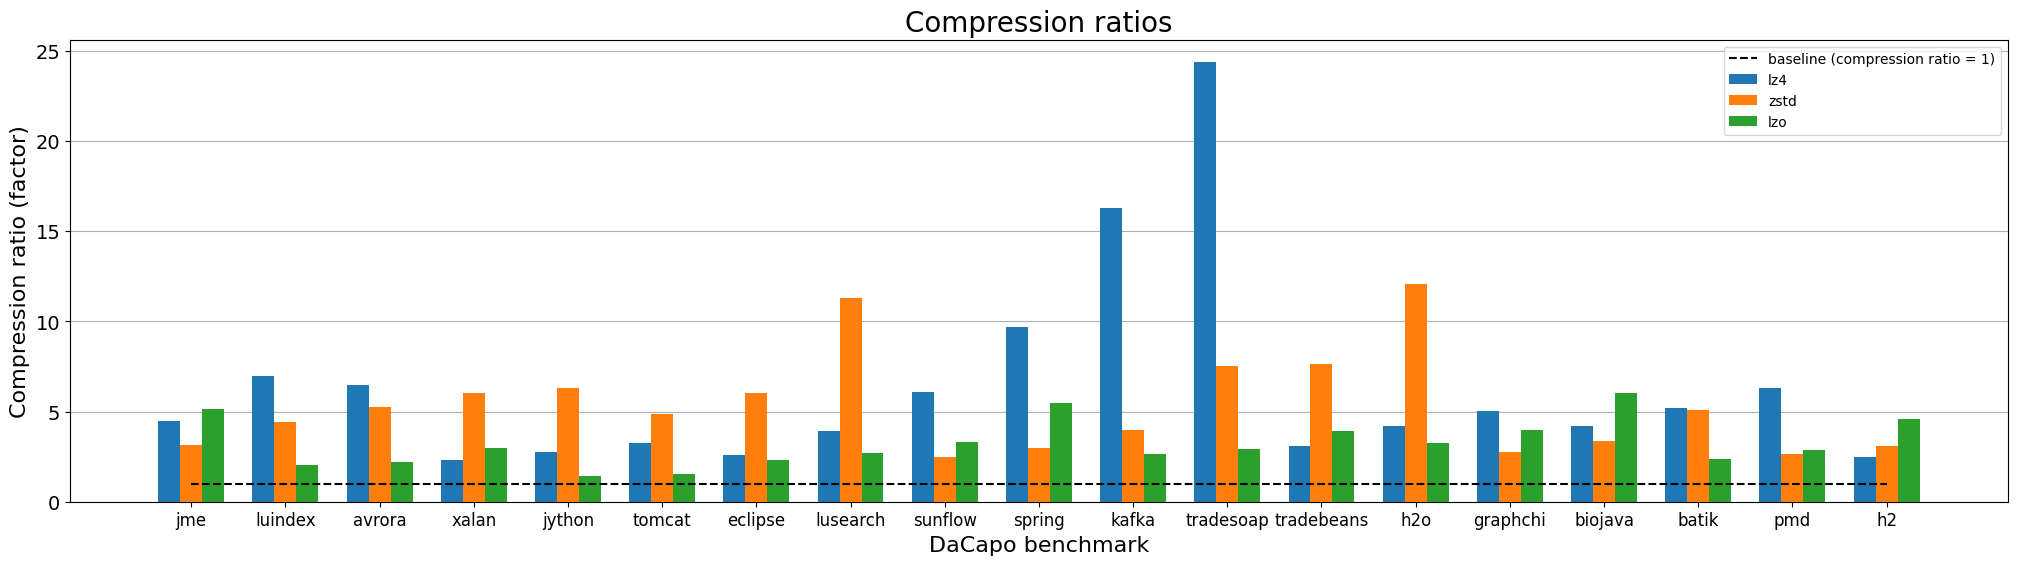

In [24]:
alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT dumpname FROM dumpsizesGB ORDER BY size_GB"),
    sqflat("SELECT AVG(compr_ratio) FROM compressionRatio AS cr INNER JOIN dumpsizesGB AS ds ON cr.benchmark = ds.dumpname WHERE compr_ratio > 0 GROUP BY benchmark, compression_alg ORDER BY ds.size_GB"),
    labels=sqflat("SELECT DISTINCT compression_alg FROM compressionRatio"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Compression ratio (factor)",
    title="Compression ratios",
    show=False
)
nb = len(sqflat("SELECT DISTINCT benchmark FROM compressionRatio"))
plt.plot(range(nb), np.ones(nb), linestyle='--', zorder=100, color="#000000", label="baseline (compression ratio = 1)") # draw a line at 1 for baseline purposes

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.legend()

plt.savefig("../../processed-data/2025-03-28-heapdump/compratios.png")
plt.show()

In [53]:
# get the amount of data compressed per benchmark
sq("SELECT benchmark, AVG(data_bytes - total_bytes)/(1024*1024*1024) AS size_deltaGB FROM compressionRatio WHERE compression_alg='zstd' GROUP BY benchmark ORDER BY size_deltaGB DESC")

,benchmark,size_deltaGB
0,h2,6.252617
1,pmd,3.362793
2,batik,2.783210
3,biojava,1.390576
4,graphchi,0.639966
5,tradebeans,0.504065
6,h2o,0.434415
7,kafka,0.271465
8,tradesoap,0.243799
9,sunflow,0.173535


In [57]:
# get the compression ratios for zstd
sq("SELECT benchmark, AVG(data_bytes / total_bytes) AS r FROM compressionRatio WHERE compression_alg='zstd' GROUP BY benchmark ORDER BY r DESC")

,benchmark,r
0,xalan,24.400702
1,kafka,12.056629
2,sunflow,11.271676
3,lusearch,6.330893
4,tomcat,6.301989
5,pmd,6.030679
6,jme,5.900176
7,biojava,5.494492
8,avrora,5.463017
9,tradebeans,5.161158


# Compression algorithms (on heap dumps)

In [108]:
dumps = pd.read_csv("../../data/2025-04-17-time-13-32-01-fourth-run-dumps/master.csv", index_col=0)

In [68]:
dumps.columns

Index(['cbSize', 'cioengine', 'ciodepth', 'crw', 'cnproc', 'cdevice',
       'cdirect', 'cmemlim', 'cdumpbc', 'cdumpno', 'cfile', 'readBW_bytes',
       'readBW', 'writeBW_bytes', 'writeBW', 'avgreadlat_ns', 'avgreadlat',
       'avgwritelat_ns', 'avgwritelat', 'USR_UTIL_perc', 'SYS_UTIL_perc',
       'IOW_UTIL_perc', 'IDL_UTIL_perc', 'CPU_UTIL_perc',
       'diskutil-TOTAL_READS(KB)', 'diskutil-TOTAL_WRITES(KB)',
       'diskutil-TOTAL_READS(MB)', 'diskutil-TOTAL_WRITES(MB)',
       'diskutil-TOTAL_READS(GB)', 'diskutil-TOTAL_WRITES(GB)',
       'diskutil-rMB/s', 'diskutil-wMB/s', 'diskutil-AVGRQ-SZ',
       'diskutil-AVGQU-SZ', 'diskutil-DEV_UTIL'],
      dtype='object')

In [69]:
# sq("SELECT cdevice, cdumpbc, AVG(readBW_bytes) FROM dumps WHERE crw='read' GROUP BY cdevice, cdumpbc")
sq("SELECT cdevice, cdumpbc, readBW_bytes FROM dumps WHERE crw='read' AND cdumpbc='h2'")

,cdevice,cdumpbc,readBW_bytes
0,zram-lz4,h2,1994100973
1,zram-lz4,h2,1802868276
2,zram-lz4,h2,1888193525
3,zram-lz4,h2,1738443377
4,zram-lz4,h2,1703698604
5,zram-zstd,h2,1652627473
6,zram-zstd,h2,1479318391
7,zram-zstd,h2,1389325467
8,zram-zstd,h2,1353622901
9,zram-zstd,h2,1313075682


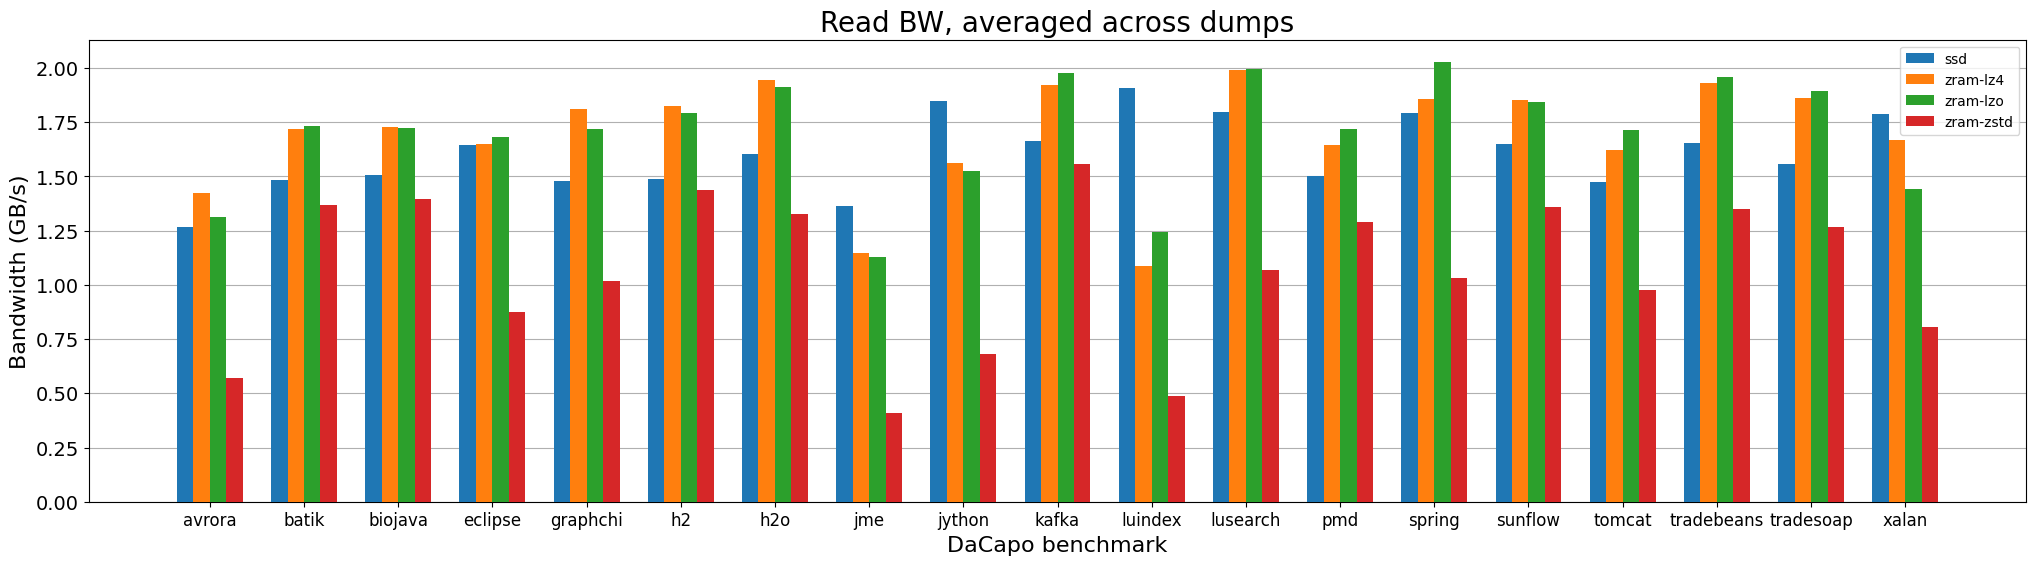

In [70]:
alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT cdumpbc FROM dumps ORDER BY cdumpbc"),
    np.array(sqflat("SELECT AVG(readBW_bytes) FROM dumps WHERE crw='read' GROUP BY cdevice, cdumpbc"))/10**9,
    labels=sqflat("SELECT DISTINCT cdevice FROM dumps ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Bandwidth (GB/s)",
    title="Read BW, averaged across dumps",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.show()

In [71]:
sq("""
    SELECT cdumpbc, cdevice, AVG(d.readBW_bytes) 
    FROM dumps AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname
    WHERE d.crw='read' AND d.cdevice !='zram-zstd'
    GROUP BY cdumpbc, cdevice
    ORDER BY ds.size_GB DESC
""")
print("suppress output")

suppress output


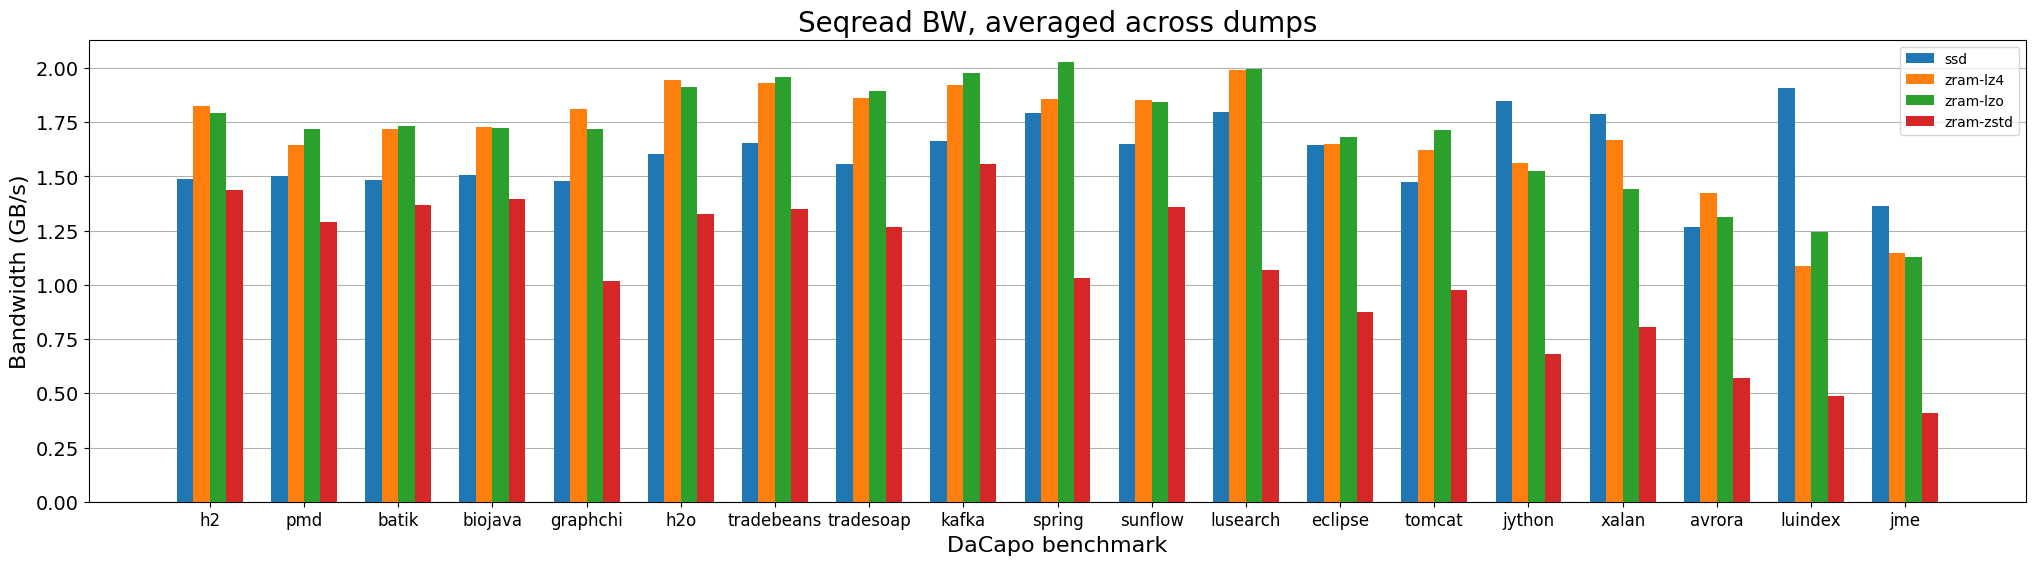

In [73]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    np.array(sqflat("SELECT AVG(d.readBW_bytes) FROM dumps AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='read' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"))/10**9,
    labels=sqflat("SELECT DISTINCT cdevice FROM dumps ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Bandwidth (GB/s)",
    title="Seqread BW, averaged across dumps",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/compAlg-seqread.png")
plt.show()

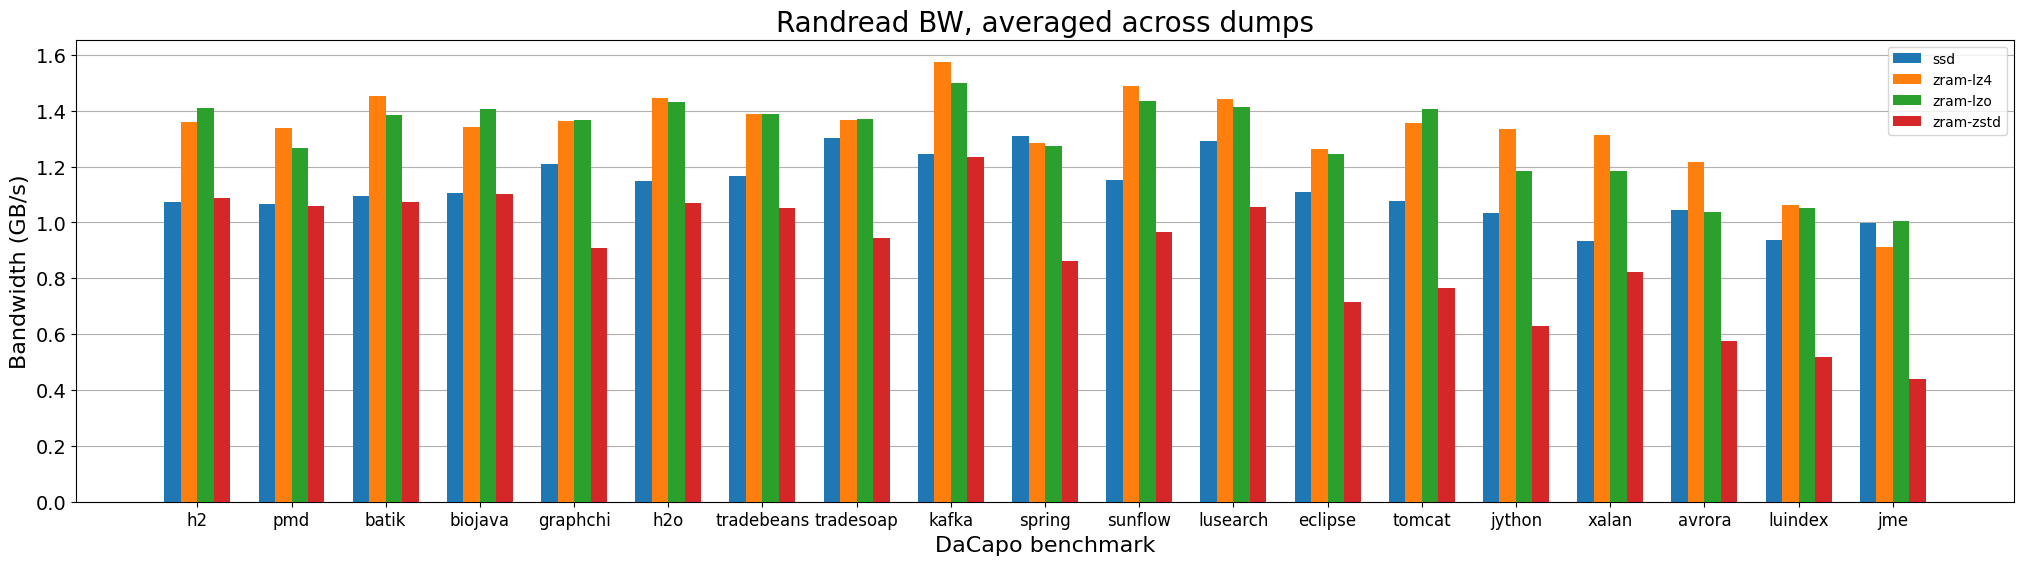

In [109]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    np.array(sqflat("SELECT AVG(d.readBW_bytes) FROM dumps AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='randread' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"))/10**9,
    labels=sqflat("SELECT DISTINCT cdevice FROM dumps ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Bandwidth (GB/s)",
    title="Randread BW, averaged across dumps",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/compAlg-randread.png")
plt.show()

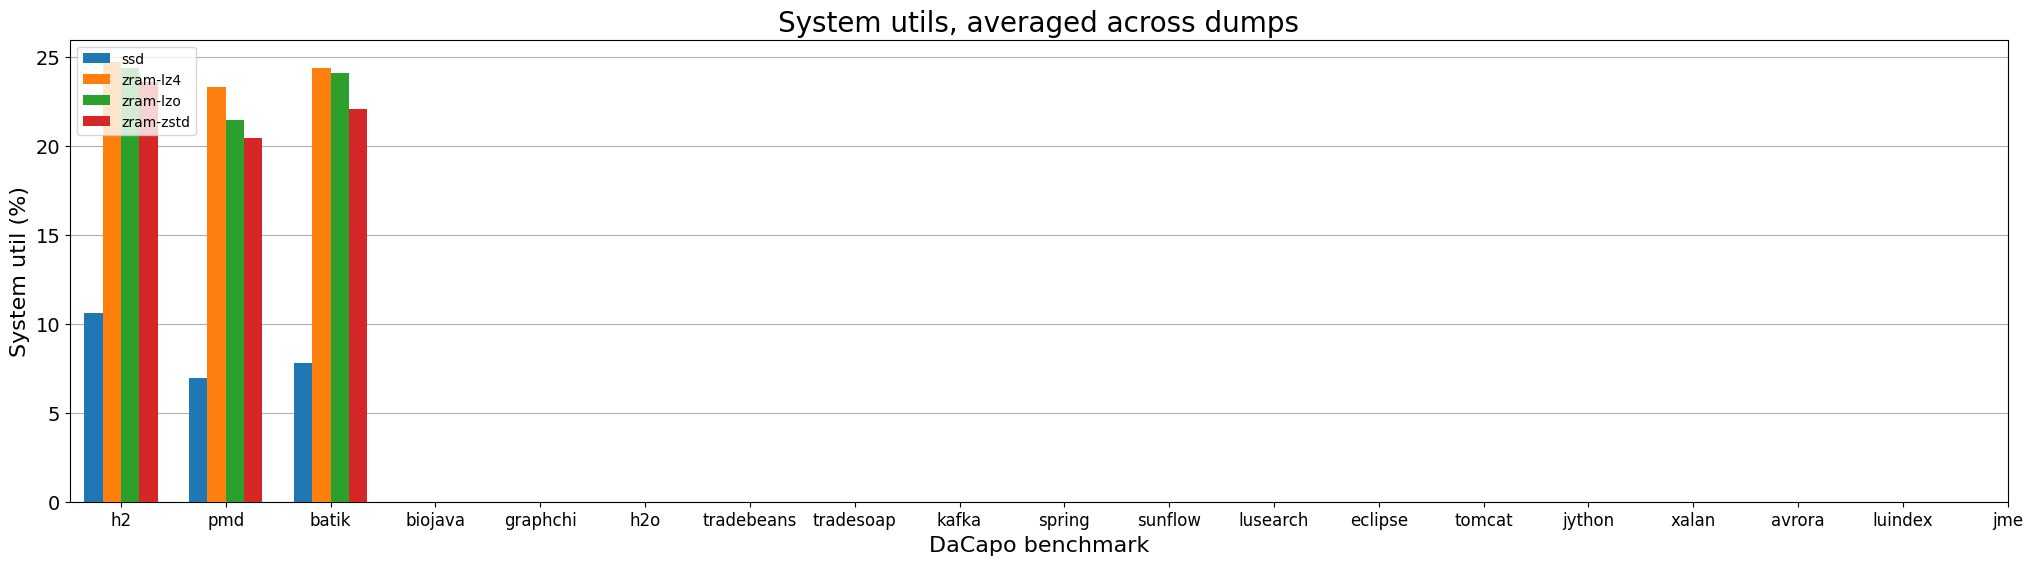

In [82]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    sqflat("SELECT AVG(d.SYS_UTIL_perc) FROM dumps AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='read' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"),
    labels=sqflat("SELECT DISTINCT cdevice FROM dumps ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="System util (%)",
    title="System utils, averaged across dumps",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/compAlg-sysutil.png")

plt.show()

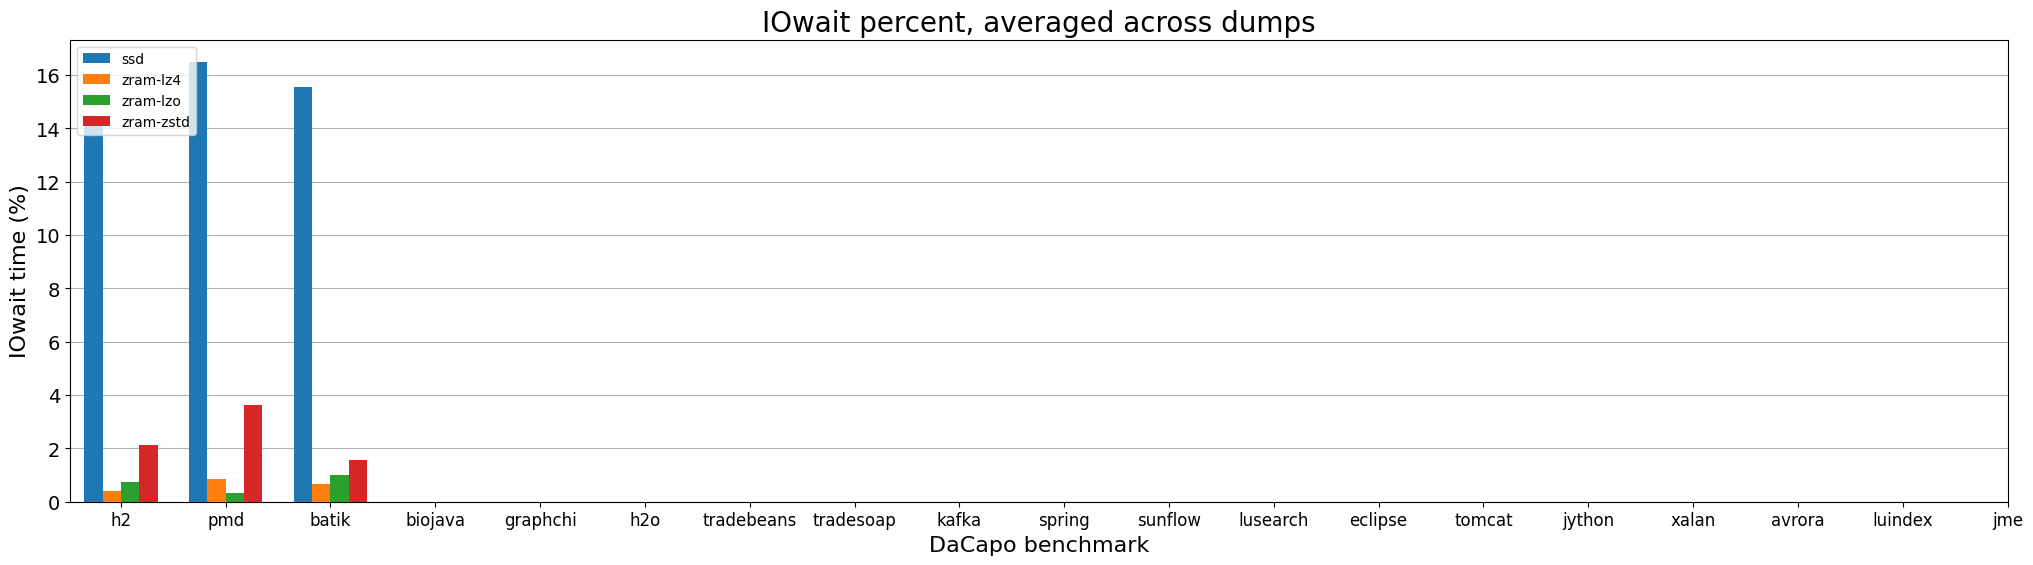

In [88]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    sqflat("SELECT AVG(d.IOW_UTIL_perc) FROM dumps AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='read' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"),
    labels=sqflat("SELECT DISTINCT cdevice FROM dumps ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="IOwait time (%)",
    title="IOwait percent, averaged across dumps",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/compAlg-iowait.png")

plt.show()

In [84]:
sq("SELECT cdevice, cdumpbc, AVG(d.SYS_UTIL_perc) FROM dumps AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='read' AND cdumpbc='h2' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC")

,cdevice,cdumpbc,AVG(d.SYS_UTIL_perc)
0,ssd,h2,10.61806
1,zram-lz4,h2,24.74268
2,zram-lzo,h2,24.39742
3,zram-zstd,h2,23.61048


i have a feeling we are observing this because i put the number of processes down to 8 whoops lol
- I'll try 32 again and check to make sure

# Compression algorithm but on extended dumps

In [106]:
dumps2 = pd.read_csv("../../data/2025-04-25-time-01-10-01-fourth-run-dumps-extendedfile/master.csv", index_col=0)

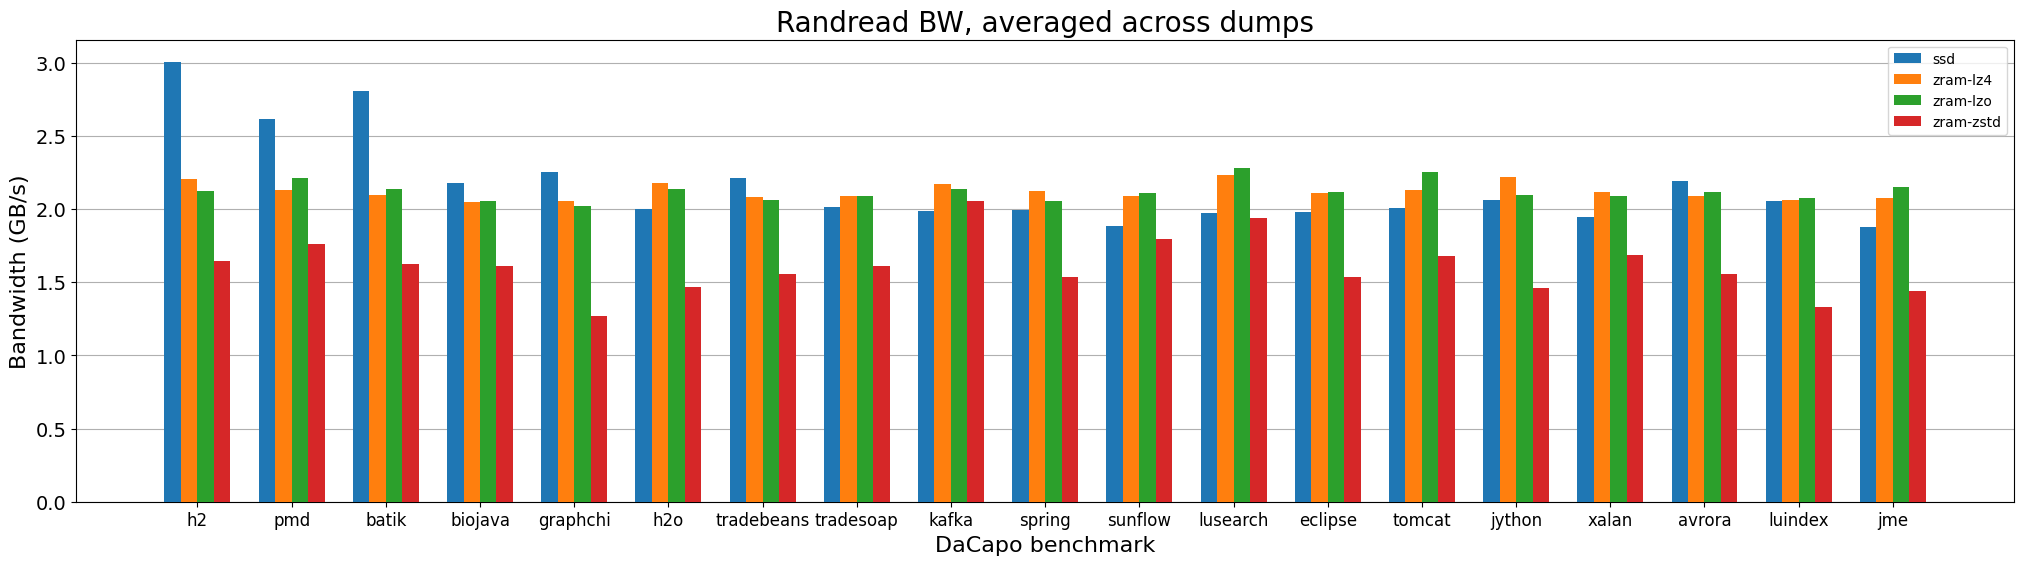

In [107]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    np.array(sqflat("SELECT AVG(d.readBW_bytes) FROM dumps2 AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='read' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"))/10**9,
    labels=sqflat("SELECT DISTINCT cdevice FROM dumps2 ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Bandwidth (GB/s)",
    title="Randread BW, averaged across dumps",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/compAlg-read-extendedfiles.png")
plt.show()

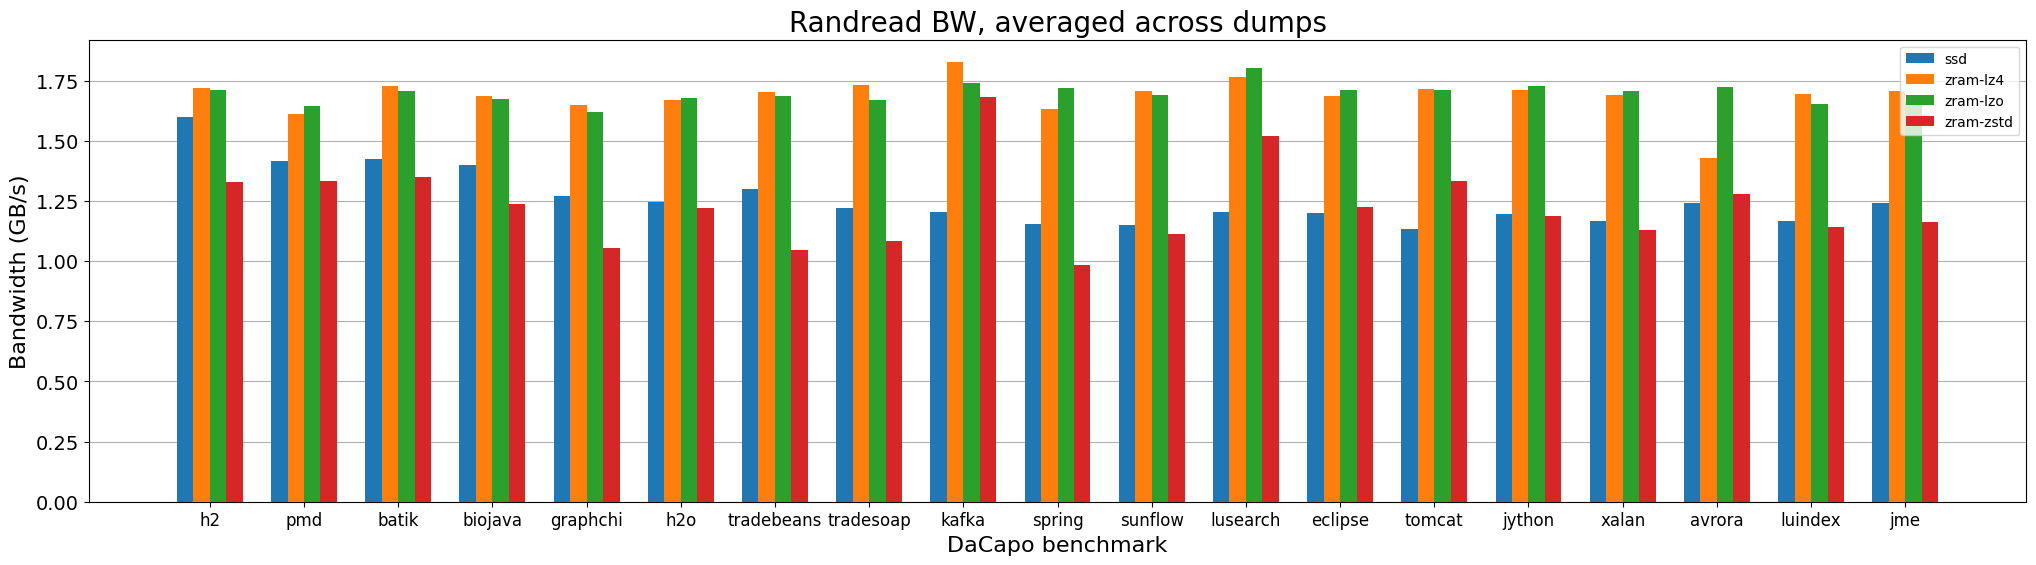

In [76]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    np.array(sqflat("SELECT AVG(d.readBW_bytes) FROM dumps2 AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='randread' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"))/10**9,
    labels=sqflat("SELECT DISTINCT cdevice FROM dumps2 ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Bandwidth (GB/s)",
    title="Randread BW, averaged across dumps",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/compAlg-randread-extendedfiles.png")
plt.show()

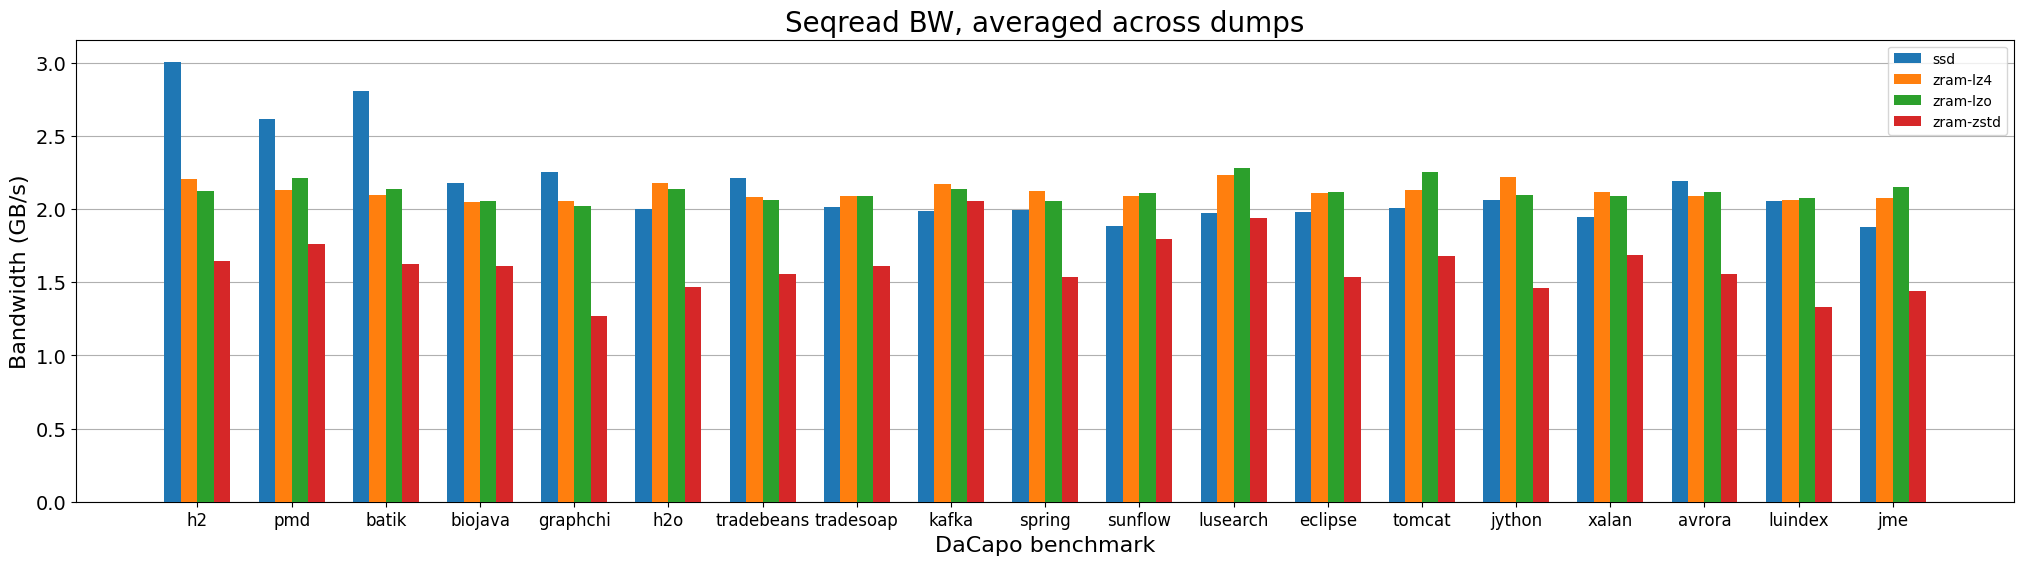

In [78]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    np.array(sqflat("SELECT AVG(d.readBW_bytes) FROM dumps2 AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='read' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"))/10**9,
    labels=sqflat("SELECT DISTINCT cdevice FROM dumps2 ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Bandwidth (GB/s)",
    title="Seqread BW, averaged across dumps",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/compAlg-seqread-extendedfiles.png")
plt.show()

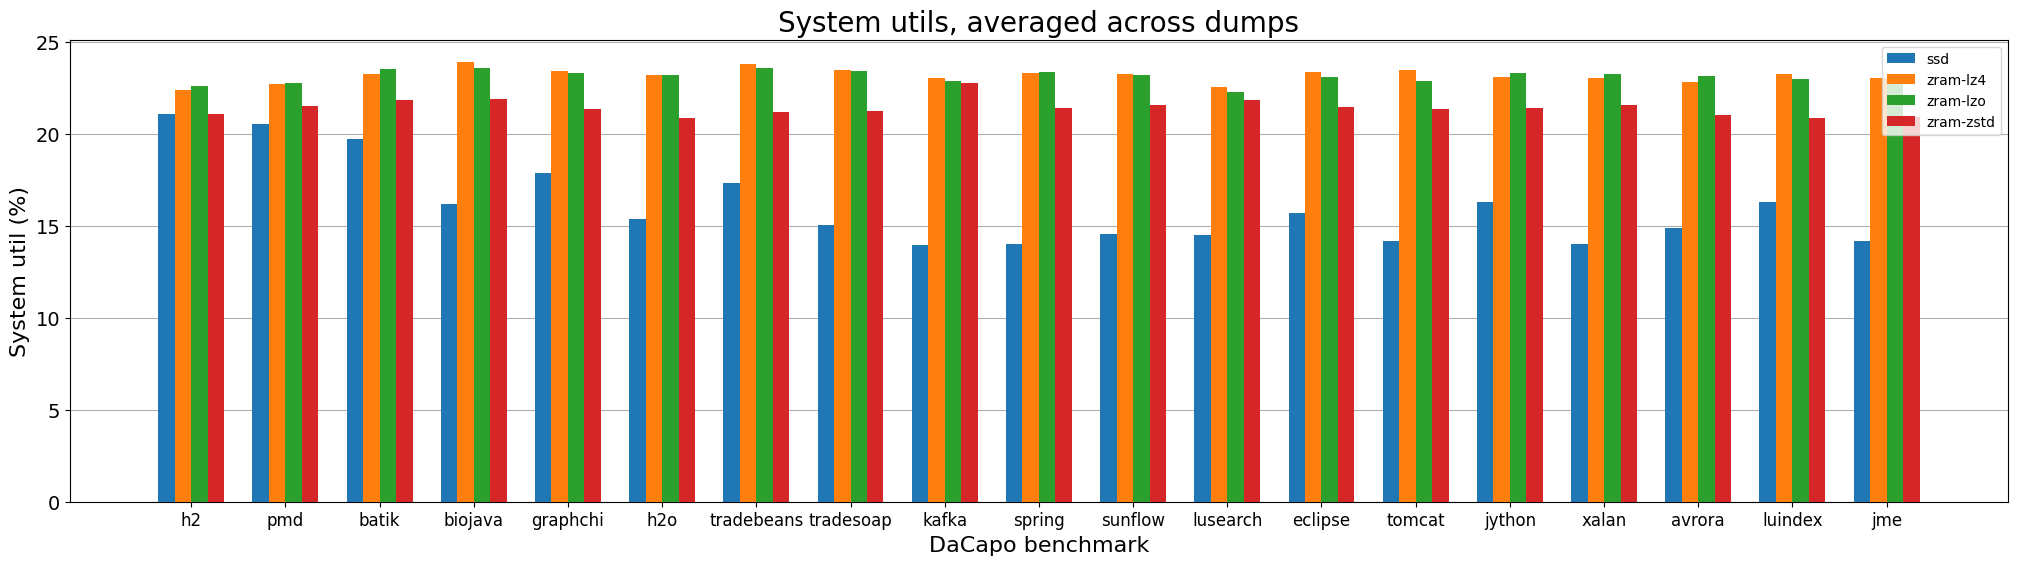

In [81]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    sqflat("SELECT AVG(d.SYS_UTIL_perc) FROM dumps2 AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='read' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"),
    labels=sqflat("SELECT DISTINCT cdevice FROM dumps ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="System util (%)",
    title="System utils, averaged across dumps",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/compAlg-sysutil-extendedfile.png")

plt.show()

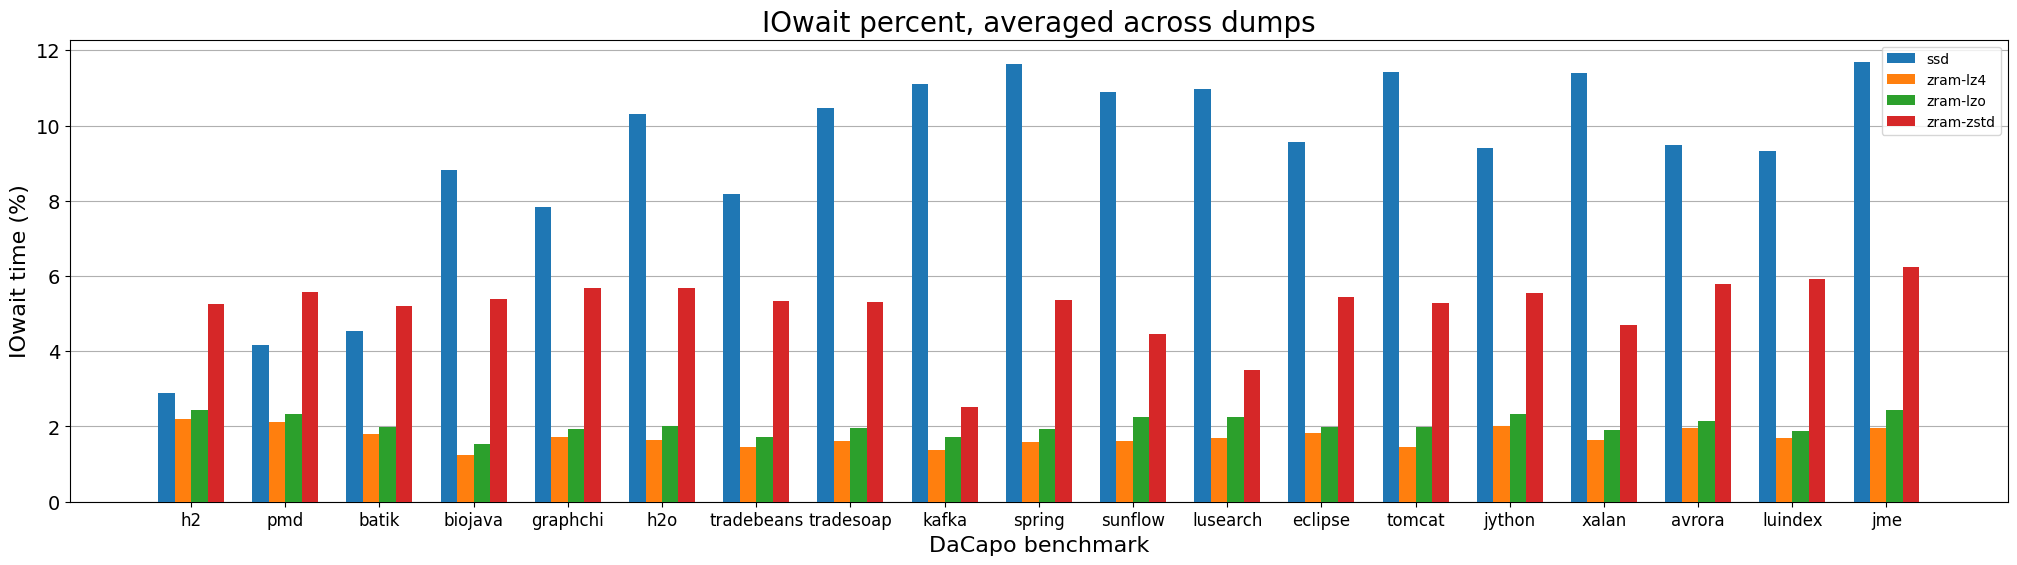

In [86]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    sqflat("SELECT AVG(d.IOW_UTIL_perc) FROM dumps2 AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='read' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"),
    labels=sqflat("SELECT DISTINCT cdevice FROM dumps ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="IOwait time (%)",
    title="IOwait percent, averaged across dumps",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/compAlg-iowait-extendedfile.png")

plt.show()

In [85]:
sq("SELECT cdevice, cdumpbc, AVG(d.SYS_UTIL_perc) FROM dumps2 AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='read' AND cdumpbc='h2' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC")

,cdevice,cdumpbc,AVG(d.SYS_UTIL_perc)
0,ssd,h2,21.06896
1,zram-lz4,h2,22.37248
2,zram-lzo,h2,22.56642
3,zram-zstd,h2,21.06650


# Latency analysis (heap dump experiments)

In [11]:
df_hd = pd.read_csv("../../data/2025-04-17-time-13-32-01-fourth-run-dumps/master.csv")
df_hd_ext = pd.read_csv("../../data/2025-04-30-time-15-29-46-fourth-run-dumps-sync/master.csv")

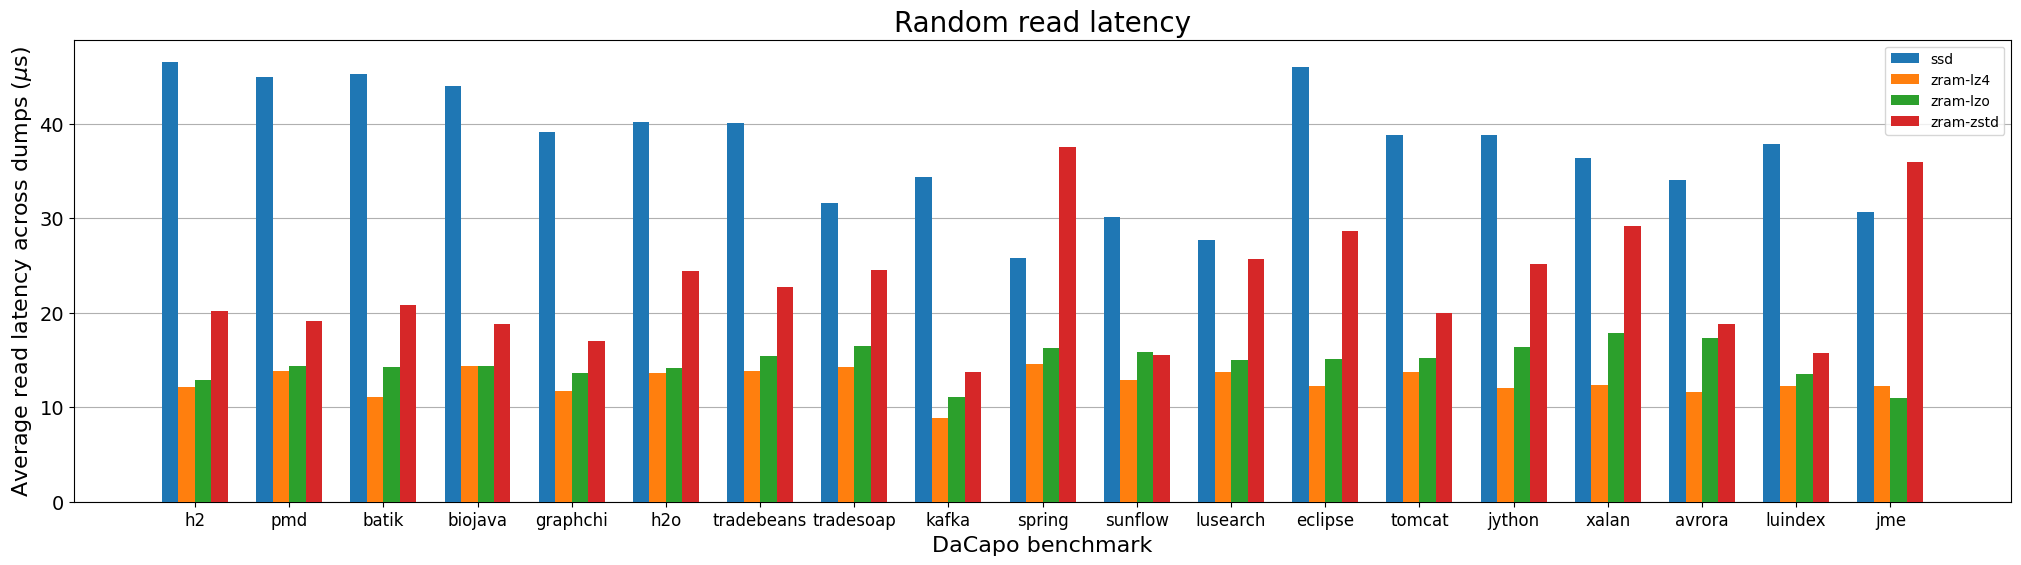

In [68]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    sqflat("SELECT AVG(d.avgreadlat) FROM df_hd AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='randread' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"),
    labels=sqflat("SELECT DISTINCT cdevice FROM df_hd ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Average read latency across dumps ($\mu$s)",
    title="Random read latency",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/randread-latency.png")

plt.show()

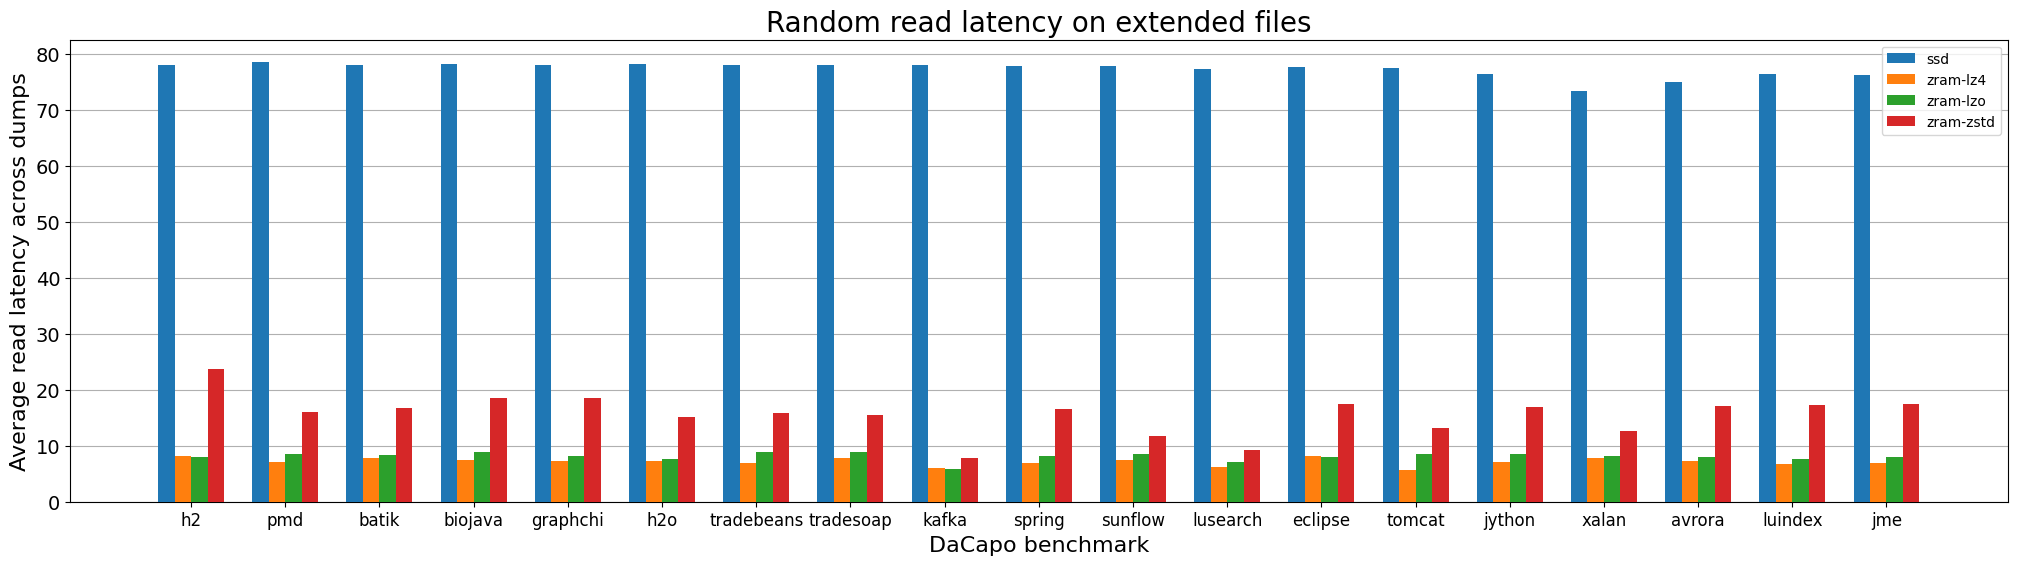

In [72]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    sqflat("SELECT AVG(d.avgreadlat) FROM df_hd_ext AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='randread' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"),
    labels=sqflat("SELECT DISTINCT cdevice FROM df_hd_ext ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Average read latency across dumps",
    title="Random read latency on extended files",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/randread-latency-extendedfile.png")

plt.show()

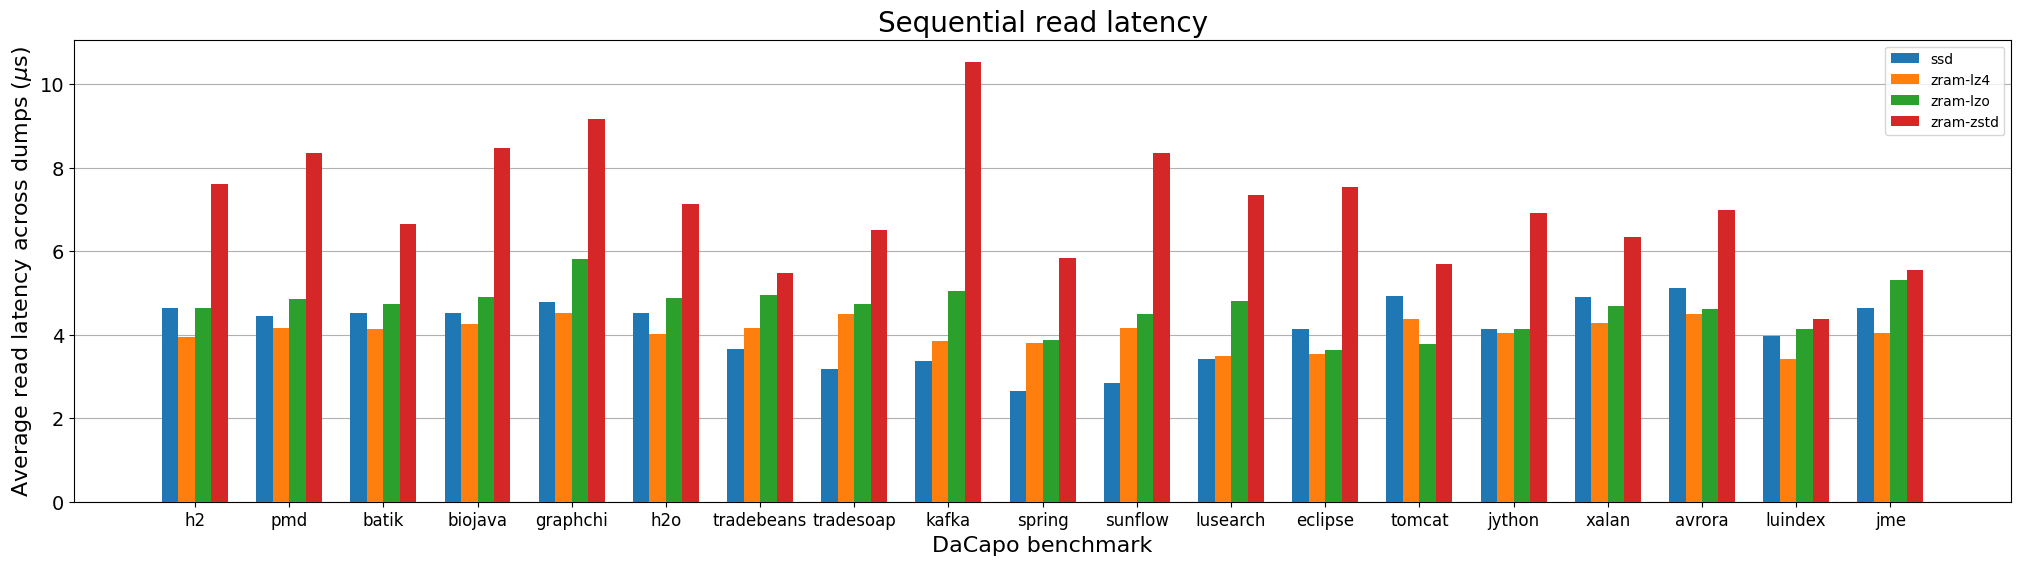

In [71]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    sqflat("SELECT AVG(d.avgreadlat) FROM df_hd AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='read' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"),
    labels=sqflat("SELECT DISTINCT cdevice FROM df_hd ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Average read latency across dumps ($\mu$s)",
    title="Sequential read latency",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/seqread-latency.png")

plt.show()

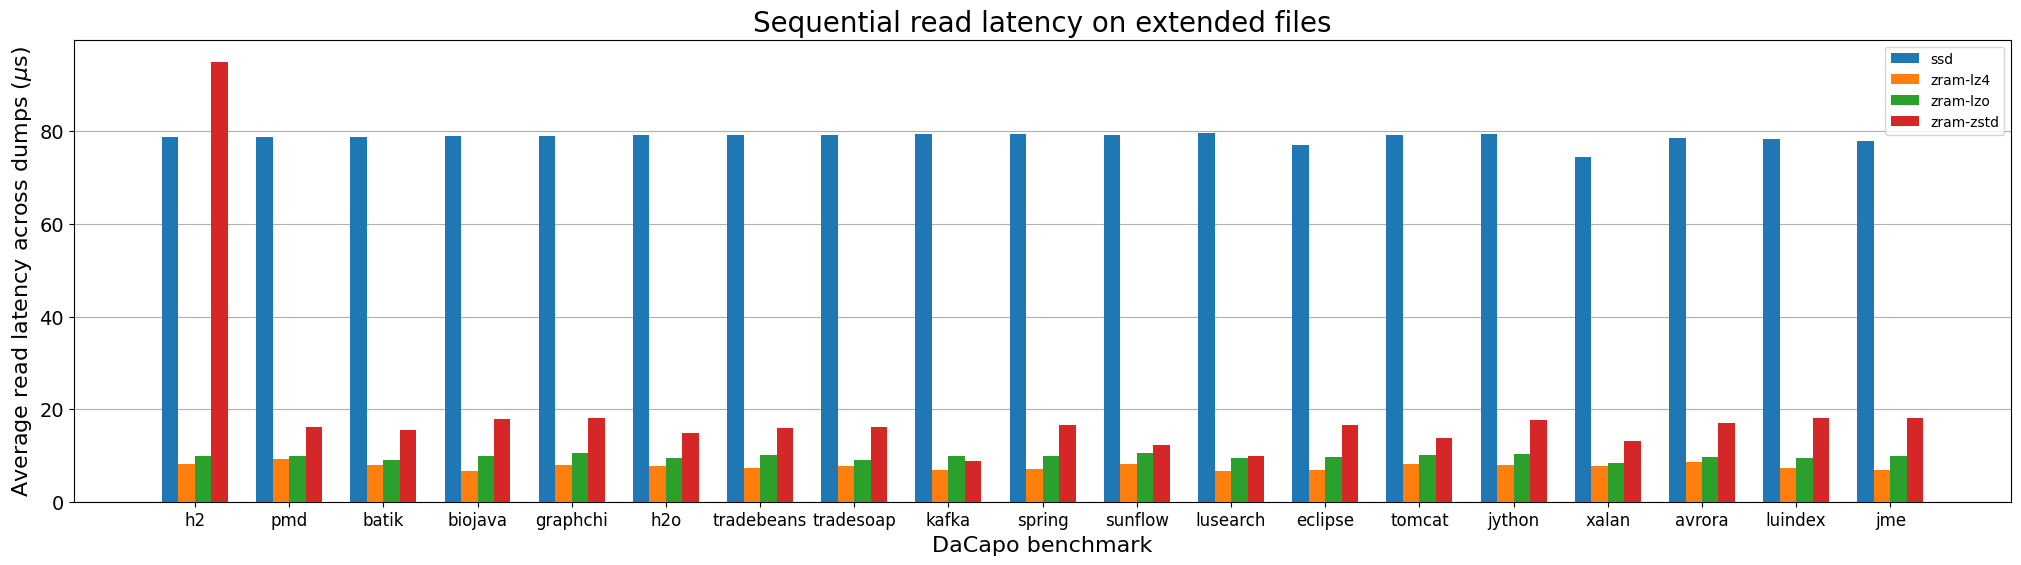

In [80]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    sqflat("SELECT AVG(d.avgreadlat) FROM df_hd_ext AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='read' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"),
    labels=sqflat("SELECT DISTINCT cdevice FROM df_hd ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Average read latency across dumps ($\mu$s)",
    title="Sequential read latency on extended files",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/seqread-latency-extendedfile.png")

plt.show()

In [85]:
sq("SELECT cdevice, cdumpbc, COUNT(*), AVG(d.readBW_bytes) FROM df_hd AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='randread' GROUP BY cdevice, cdumpbc ORDER BY ds.size_GB DESC, cdevice")

,cdevice,cdumpbc,COUNT(*),AVG(d.readBW_bytes)
0,ssd,h2,5,1.074628e+09
1,zram-lz4,h2,5,1.359733e+09
2,zram-lzo,h2,5,1.408022e+09
3,zram-zstd,h2,5,1.086910e+09
4,ssd,pmd,2,1.066932e+09
...,...,...,...,...
71,zram-zstd,luindex,5,5.177953e+08
72,ssd,jme,5,9.989884e+08
73,zram-lz4,jme,5,9.128536e+08
74,zram-lzo,jme,5,1.006359e+09


# (Debugging) using sync engine instead

In [87]:
df_hd_sync = pd.read_csv("../../data/2025-04-30-time-15-29-46-fourth-run-dumps-sync/master.csv")

In [88]:
sq("SELECT cdevice, cdumpbc, cdumpno, avgreadlat_ns FROM df_hd_sync")

,cdevice,cdumpbc,cdumpno,avgreadlat_ns
0,zram-lz4,jme,9,5544.523708
1,zram-lz4,jme,3,5943.160202
2,zram-lz4,jme,1,5750.618361
3,zram-lz4,jme,7,8353.810971
4,zram-lz4,jme,5,8822.834112
...,...,...,...,...
683,zram-lzo,batik,11,10024.225680
684,zram-lzo,batik,8,7703.935081
685,zram-lzo,batik,2,6880.007249
686,zram-lzo,batik,5,9599.163764


In [93]:
sq("SELECT cdevice, cdumpbc, AVG(avgreadlat_ns) FROM df_hd_sync WHERE crw = 'read' GROUP BY cdevice, cdumpbc ORDER BY cdumpbc")

,cdevice,cdumpbc,AVG(avgreadlat_ns)
0,ssd,avrora,78453.646392
1,zram-lz4,avrora,8535.993275
2,zram-lzo,avrora,9634.909524
3,zram-zstd,avrora,16961.572606
4,ssd,batik,78767.183885
...,...,...,...
71,zram-zstd,tradesoap,16232.050371
72,ssd,xalan,74472.514503
73,zram-lz4,xalan,7718.204659
74,zram-lzo,xalan,8321.021051


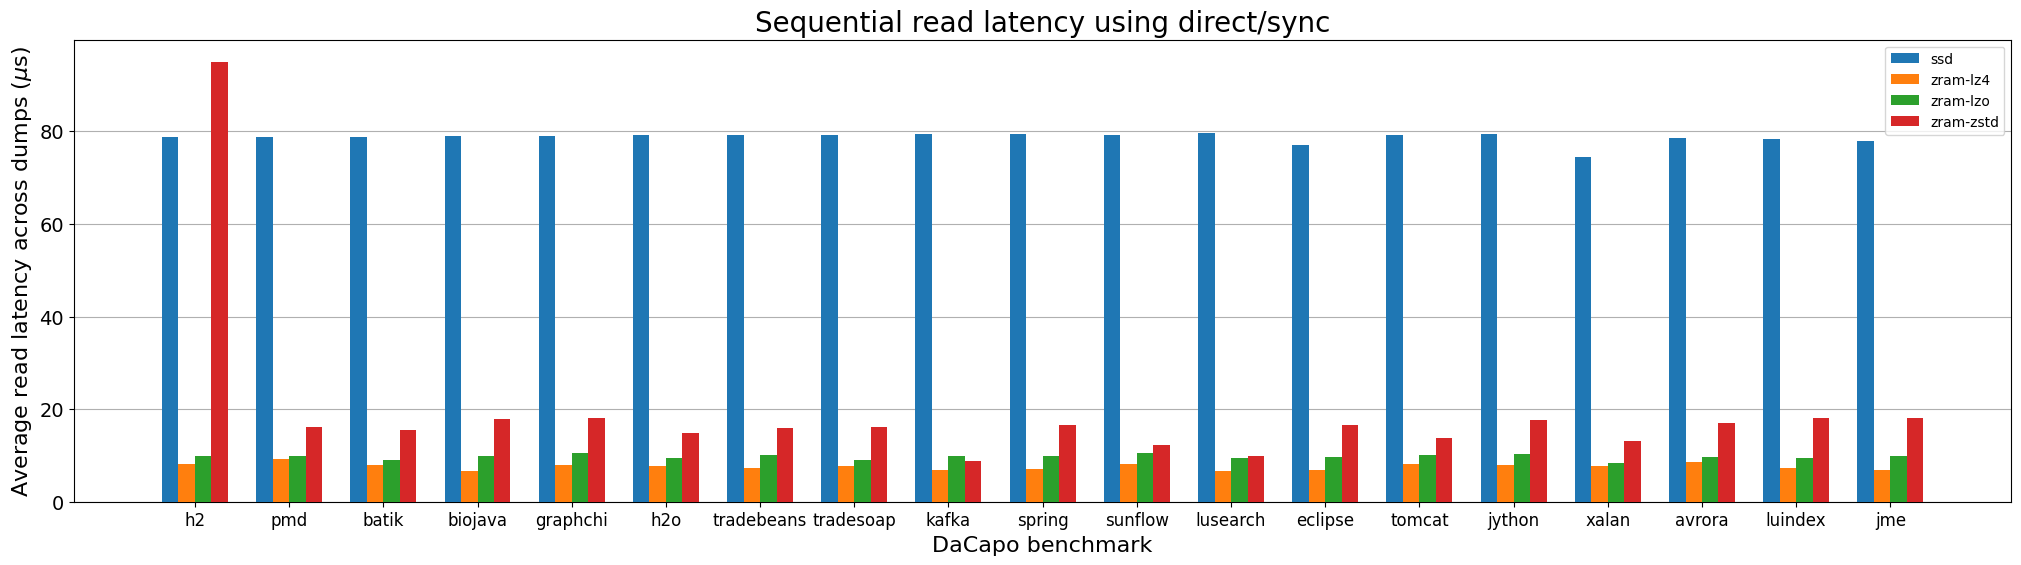

In [94]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    sqflat("SELECT AVG(d.avgreadlat) FROM df_hd_sync AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='read' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"),
    labels=sqflat("SELECT DISTINCT cdevice FROM df_hd ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Average read latency across dumps ($\mu$s)",
    title="Sequential read latency using direct/sync",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/seqread-latency-sync.png")

plt.show()

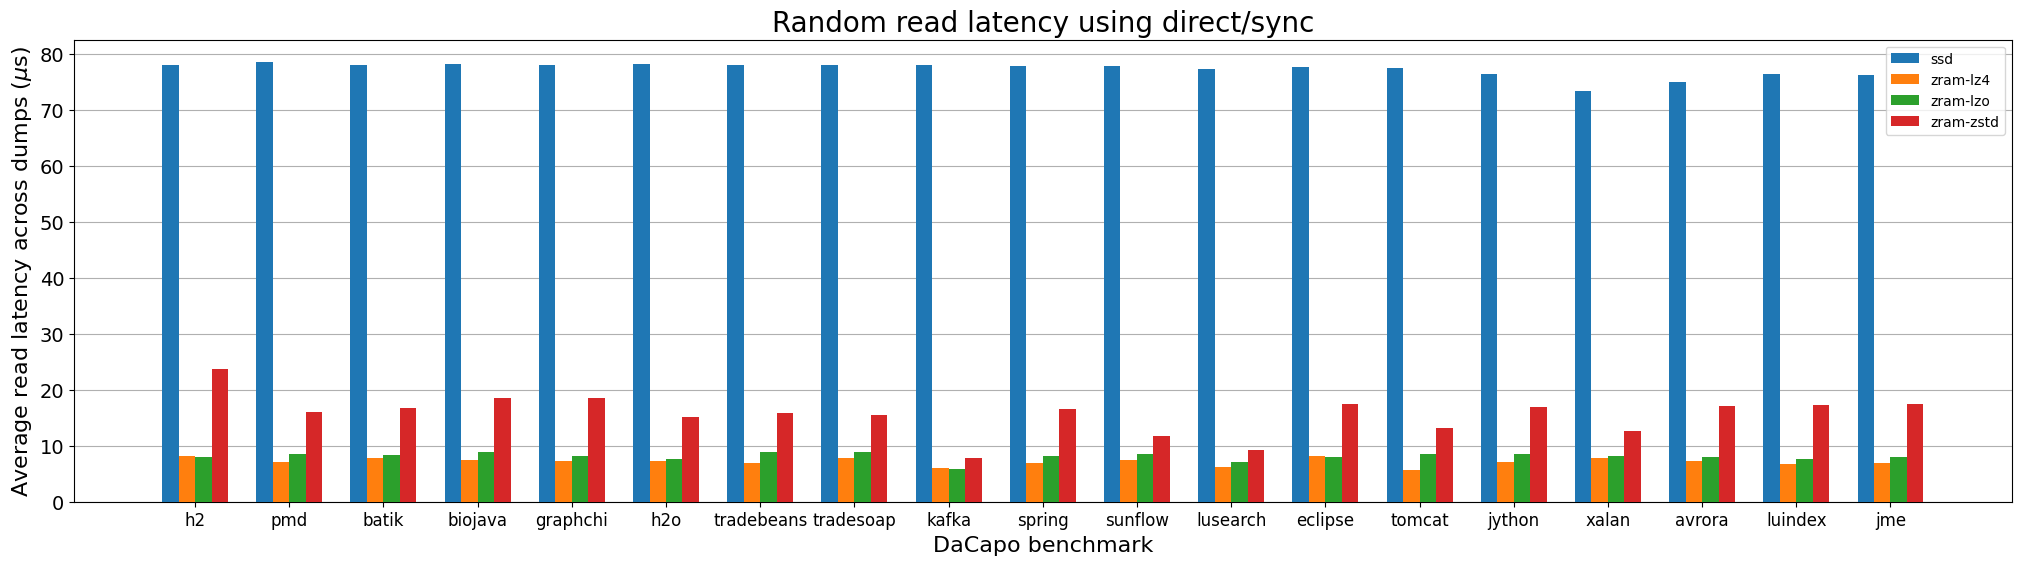

In [96]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    sqflat("SELECT AVG(d.avgreadlat) FROM df_hd_sync AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='randread' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"),
    labels=sqflat("SELECT DISTINCT cdevice FROM df_hd ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Average read latency across dumps ($\mu$s)",
    title="Random read latency using direct/sync",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/randread-latency-sync.png")

plt.show()

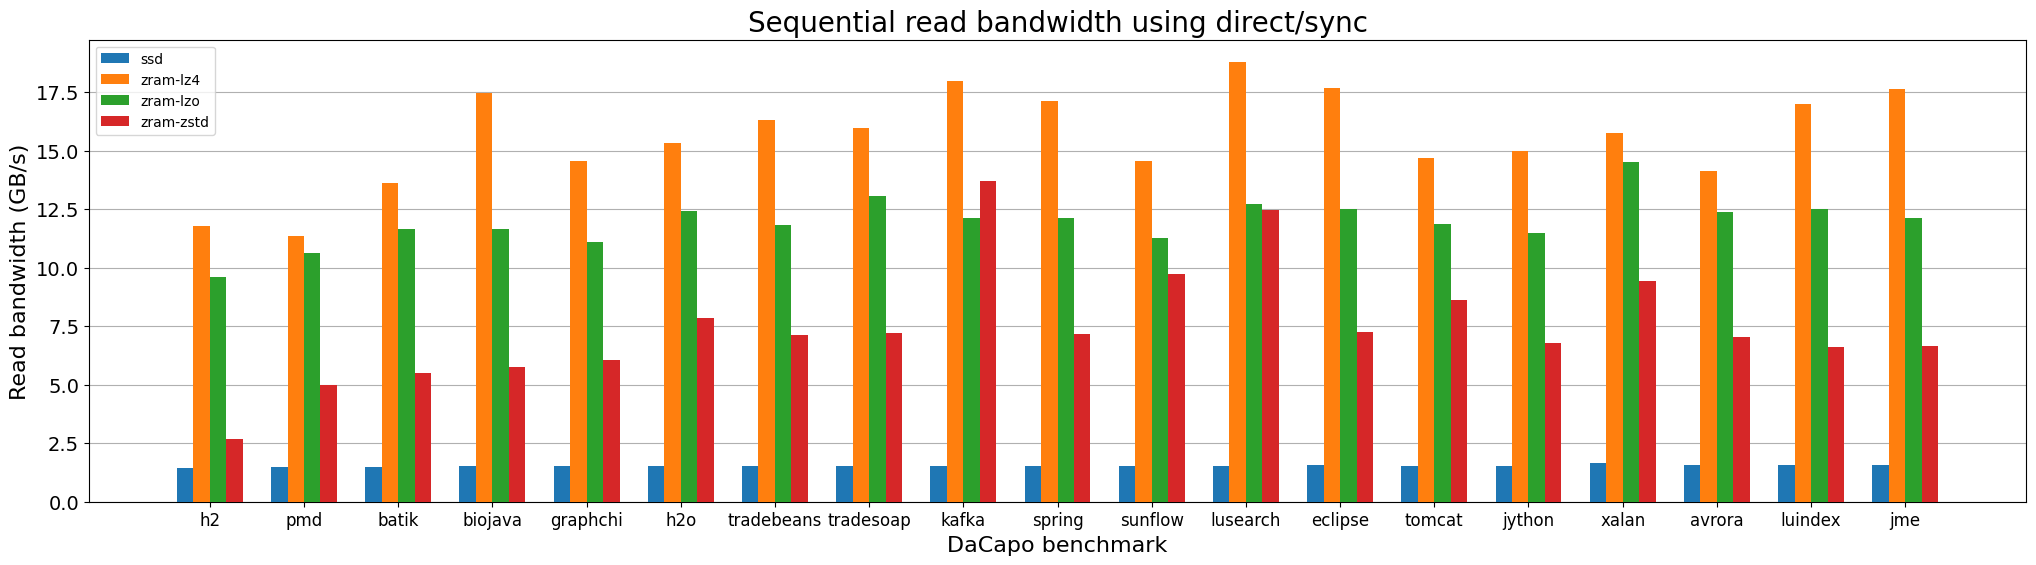

In [104]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    sqflat("SELECT AVG(d.readBW_bytes)/(1024*1024*1024) FROM df_hd_sync AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='read' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"),
    labels=sqflat("SELECT DISTINCT cdevice FROM df_hd ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Read bandwidth (GB/s)",
    title="Sequential read bandwidth using direct/sync",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/seqread-bw-sync.png")

plt.show()

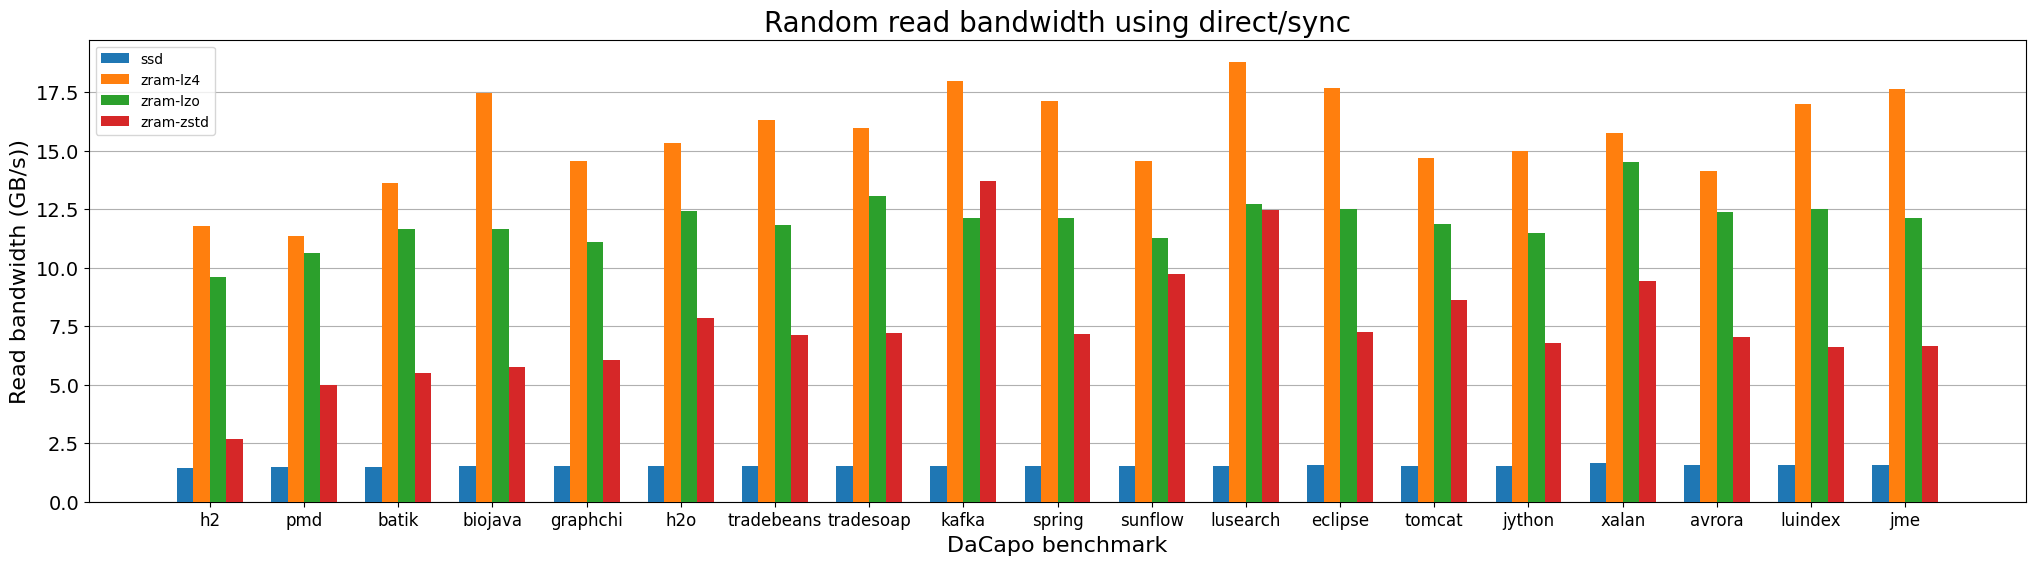

In [105]:
alib.grouped_barplot_flat(
    sqflat("SELECT dumpname FROM dumpsizesGB ORDER BY size_GB DESC"),
    sqflat("SELECT AVG(d.readBW_bytes)/(1024*1024*1024) FROM df_hd_sync AS d INNER JOIN dumpsizesGB AS ds ON d.cdumpbc = ds.dumpname WHERE d.crw='read' GROUP BY cdevice, cdumpbc ORDER BY cdevice, ds.size_GB DESC"),
    labels=sqflat("SELECT DISTINCT cdevice FROM df_hd ORDER BY cdevice"),
    figsize=[25, 6],
    xlabel="DaCapo benchmark",
    ylabel="Read bandwidth (GB/s))",
    title="Random read bandwidth using direct/sync",
    show=False
)

plt.gca().get_yaxis().label.set_fontsize(16)
plt.gca().get_xaxis().label.set_fontsize(16)
plt.gca().title.set_fontsize(20)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=14)

plt.savefig("../../processed-data/2025-04-18-heapdump-2/randread-bw-sync.png")

plt.show()